In [1]:
## ---- Partition Cell Set Network Module Analysis ---- 0680.00.00
## Load Analysis Parameters (Parm1)
## Load Network Utilities
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Plot Early Attempts at Heatmaps, Experimenting with Format


In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)
library(igraph)
library(corpcor)
library(fdrtool)
library(readxl)
library(mixOmics)

In [6]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
            'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [10]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [11]:
## Declare Tom's best genes for definiting cell types
toms_markers7 <- c('AIF1', 'CD14', 'CD68',
                   'VWF', 'PECAM1', 'ECSCR',
                   'CALD1', 'MYL9', 'TAGLN',
                   'NKG7', 'XCL', 'CTSW',
                   'CD2', 'TRAC', 'CD69',
                   'CD79A', 'MS4A1', 'IGKC')

toms_gene_ids7 <- short2geneid[toms_markers7]
toms_gene_ids7

AIF1              CD14              CD68               VWF 
"ENSG00000204472" "ENSG00000170458" "ENSG00000129226" "ENSG00000110799" 
           PECAM1             ECSCR             CALD1              MYL9 
"ENSG00000261371" "ENSG00000249751" "ENSG00000122786" "ENSG00000101335" 
            TAGLN              NKG7              <NA>              CTSW 
"ENSG00000149591" "ENSG00000105374"                NA "ENSG00000172543" 
              CD2              TRAC              CD69             CD79A 
"ENSG00000116824" "ENSG00000277734" "ENSG00000110848" "ENSG00000105369" 
            MS4A1              IGKC 
"ENSG00000156738" "ENSG00000211592"

In [17]:
hallmarks_file <- paste(ps$outdir, 'Heatmaps/',
            'Hallmarks_genes_VSMCandEC_forHeatmap.Rev1.xlsx', sep = '')
hm <- suppressWarnings(read_xlsx(hallmarks_file, col_names = FALSE))
hm <- hm[, c(1, 3:13)]
hm[2:3, 1] <- hm[1, 1]
hm[5:6, 1] <- hm[4, 1]
hm[8:9, 1] <- hm[7, 1]
hm[11:12, 1] <- hm[10, 1]
colnames(hm) <- c('cell.type', 'pathway', 'gene01', 'gene02', 'gene03', 'gene04',
                 'gene05', 'gene06', 'gene07', 'gene08', 'gene09', 'gene10')

## Let's just deal with vsmc cells for now
hm <- hm[1:6, ]
hmgenes <- unique(as.vector(as.matrix(hm[, 3:12])))
pcagenes <- hmgenes

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* … and 8 more problems


In [19]:
hmgenes_tagged <- hmgenes
for (hm_n in 1:6) {
    for (gene_n in 3:12) {
        mapped2gene <- which(hmgenes %in% hm[hm_n, gene_n])
        hmgenes_tagged[mapped2gene] <- paste(hmgenes_tagged[mapped2gene], ', hm', hm_n, sep = '')
    }
}

In [24]:
## Get the Expression Set vsmc only
vsmc_bool <- (colData(down_stdycds)$assigned_cell_type == celltypes6[3])
hm_cds <- down_stdycds[fData(down_stdycds)@rownames %in% short2geneid[pcagenes], vsmc_bool]

table(colData(hm_cds)$assigned_cell_type)
expdat <- as.matrix(exprs(hm_cds))
rownames(expdat) <- hmgenes_tagged # geneid2short[rownames(expdat)]
colData(hm_cds)$condtype <- paste(c('vsmc', 'ec')[(colData(hm_cds)$assigned_cell_type == celltypes6[2]) + 1],
                                  c('hea', 'dis')[(colData(hm_cds)$condition == 'diseased') + 1],
                                                   sep = '-')
colData(hm_cds)$sidecolor[colData(hm_cds)$condtype == 'ec-dis'] <- 'red'
colData(hm_cds)$sidecolor[colData(hm_cds)$condtype == 'ec-hea'] <- 'blue'
colData(hm_cds)$sidecolor[colData(hm_cds)$condtype == 'vsmc-dis'] <- 'orange'
colData(hm_cds)$sidecolor[colData(hm_cds)$condtype == 'vsmc-hea'] <- 'cyan'
table(colData(hm_cds)$condtype)
table(colData(hm_cds)$sidecolor)


3-VSMCs 
   3672 


vsmc-dis vsmc-hea 
    1223     2449 


  cyan orange 
  2449   1223 

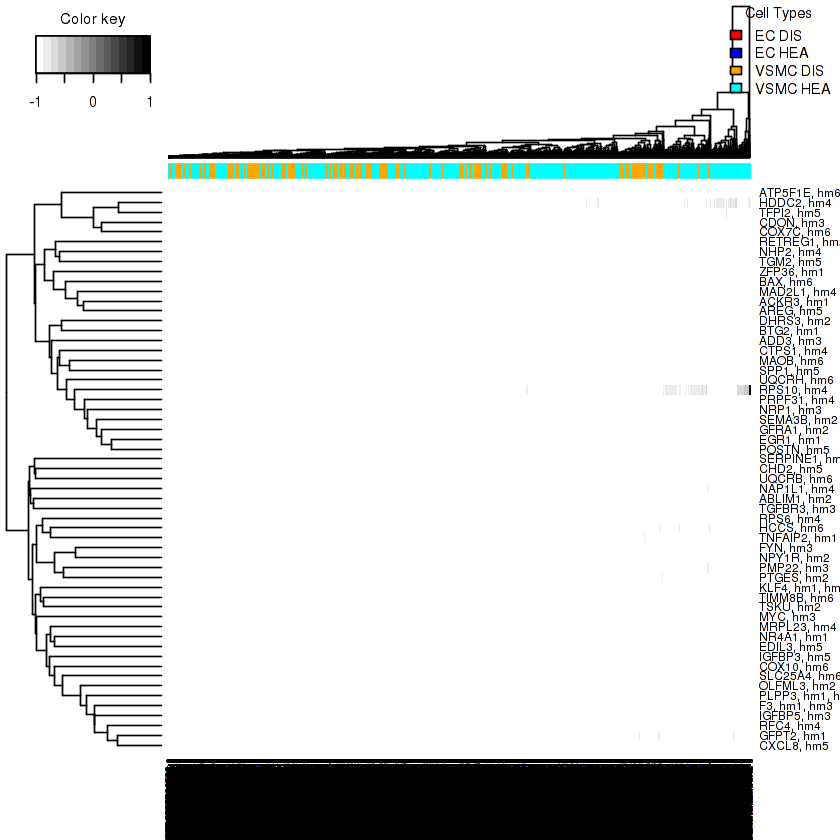

In [39]:
expdatlin <- (expdat - 1/2 * max(expdat)) * 2 / max(expdat)
my_palettelin <- colorRampPalette(c("white", "black"))(n = 15)
legendlst <- list(legend = c('EC DIS', 'EC HEA', 'VSMC DIS', 'VSMC HEA'),
              col = c('red', 'blue', 'orange', 'cyan'), title = 'Cell Types', cex = .7)
cim(expdatlin, dist.method = c('correlation', 'euclidean'), scale = FALSE,
   col.sideColors = colData(hm_cds)$sidecolor, legend = legendlst, color = my_palettelin)

In [31]:
dim(expdatlin)

[1]   57 3672

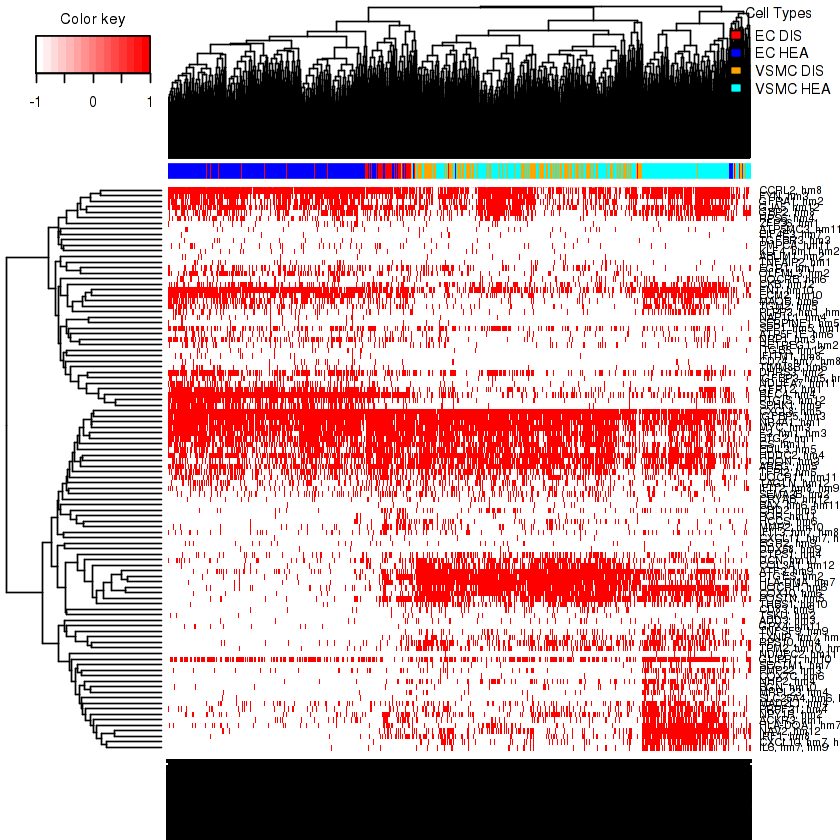

In [133]:
expdatbol <- (1 * (expdat > 0) - .5) * 2
my_palettebol <- colorRampPalette(c("white", "red"))(n = 15)
legendlstbol <- list(legend = c('EC DIS', 'EC HEA', 'VSMC DIS', 'VSMC HEA'),
              col = c('red', 'blue', 'orange', 'cyan'), title = 'Cell Types', cex = .7)
cim(expdatbol, dist.method = c('correlation', 'correlation'), scale = FALSE,
    col.sideColors = colData(hm_cds)$sidecolor, legend = legendlstbol, color = my_palettebol)

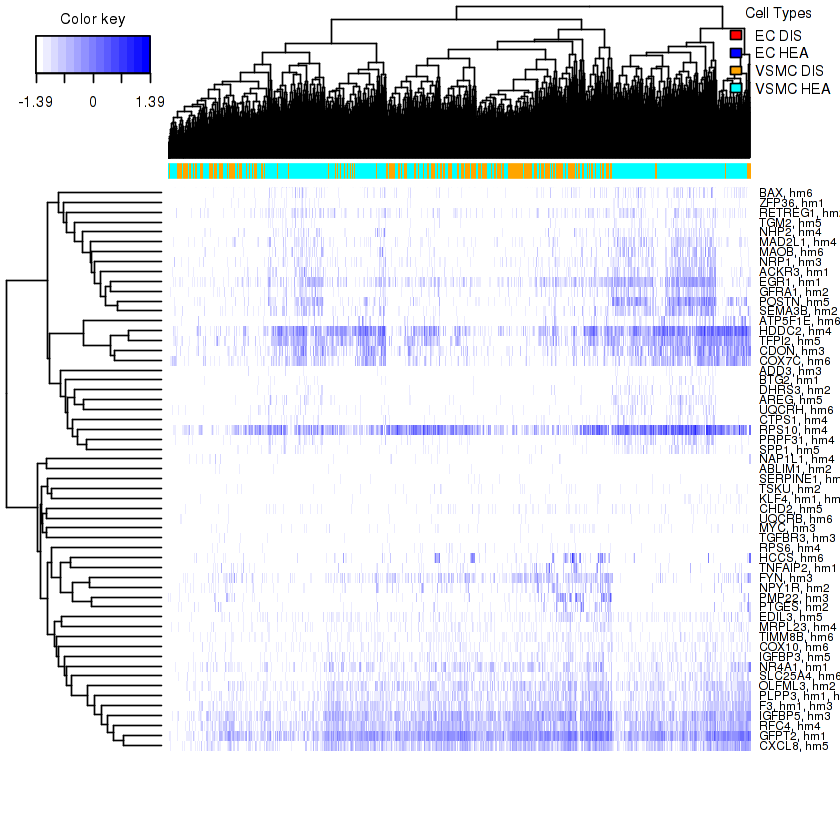

In [41]:
expdatlog <- log10(1 + expdat)
expdatlog <- expdatlog - 1/2 * max(expdatlog)
my_palettelog <- colorRampPalette(c("white", "blue"))(n = 15)
cim(expdatlog , dist.method = c('correlation', 'euclidean'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = FALSE,
    legend = legendlst, col.names = FALSE, color = my_palettelog)

In [151]:
pdf('Hallmark.Heatmap.Corr.Complete.Raw.Expression.Parts.2.3.Cells.Rev6.pdf', width = 8, height = 12)
expdatlin <- (expdat - 1/2 * max(expdat)) * 2 / max(expdat)
my_palettelin <- colorRampPalette(c("white", "black"))(n = 15)
legendlst <- list(legend = c('EC DIS', 'EC HEA', 'VSMC DIS', 'VSMC HEA'),
              col = c('red', 'blue', 'orange', 'cyan'), title = 'Cell Types', cex = .7)
cim(expdatlin, dist.method = c('correlation', 'correlation'), scale = FALSE,
    col.sideColors = colData(hm_cds)$sidecolor, legend = legendlstbol, color = my_palettelin)
dev.off()




pdf('Hallmark.Heatmap.Corr.Complete.NonZero.Expression.Parts.2.3.Cells.Rev6.pdf', width = 8, height = 12)
expdatbol <- (1 * (expdat > 0) - .5) * 2
my_palettebol <- colorRampPalette(c("white", "red"))(n = 15)
legendlstbol <- list(legend = c('EC DIS', 'EC HEA', 'VSMC DIS', 'VSMC HEA'),
              col = c('red', 'blue', 'orange', 'cyan'), title = 'Cell Types', cex = .7)
cim(expdatbol, dist.method = c('correlation', 'correlation'), scale = FALSE,
    col.sideColors = colData(hm_cds)$sidecolor, legend = legendlstbol, color = my_palettebol)
dev.off()




pdf('Hallmark.Heatmap.Corr.Complete.Plus1Log.Expression.Parts.2.3.Cells.Rev6.pdf', width = 8, height = 12)
expdatlog <- log10(1 + expdat)
expdatlog <- expdatlog - 1/2 * max(expdatlog)
my_palettelog <- colorRampPalette(c("white", "blue"))(n = 15)
cim(expdatlog , dist.method = c('correlation', 'correlation'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = FALSE,
    legend = legendlst, col.names = FALSE, color = my_palettelog)
dev.off()

png 
  2

png 
  2

png 
  2

In [149]:
pdf('Histogram.Raw.Expression.Parts.2.3.Cells.Rev6.pdf', width = 5, height = 5)
hist(expdat, breaks = 100)
dev.off()

png 
  2

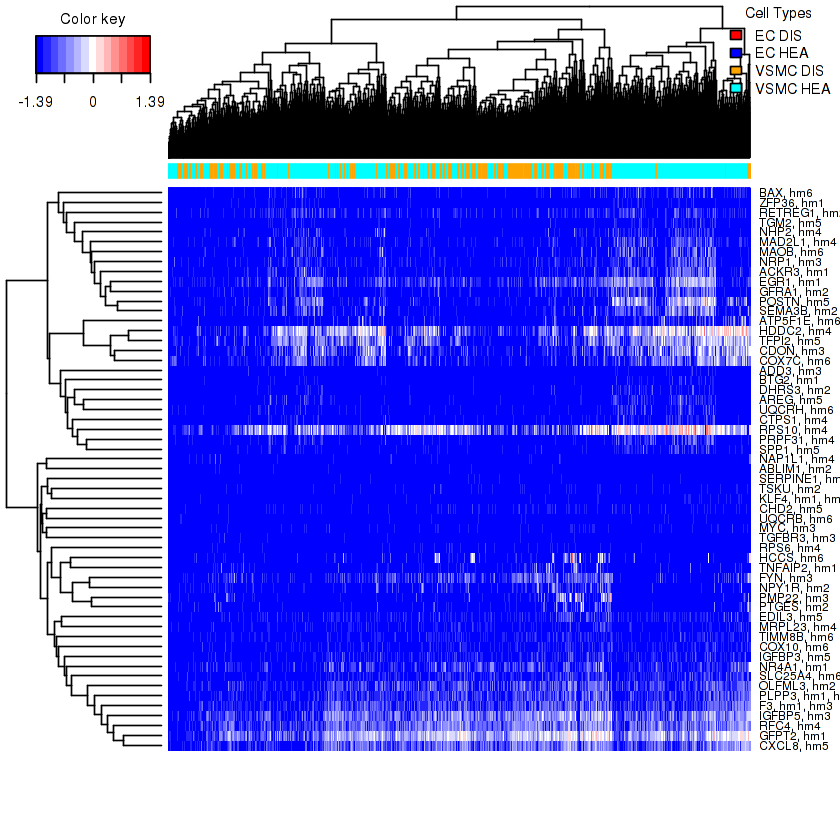

In [42]:
expdatlog2 <- log10(1 + expdat)
expdatlog2 <- expdatlog2 - 1/2 * max(expdatlog2)
my_palettelog2 <- colorRampPalette(c("blue", "white", "red"))(n = 15)
cim(expdatlog2 , dist.method = c('correlation', 'euclidean'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = FALSE,
    legend = legendlst, col.names = FALSE, color = my_palettelog2)

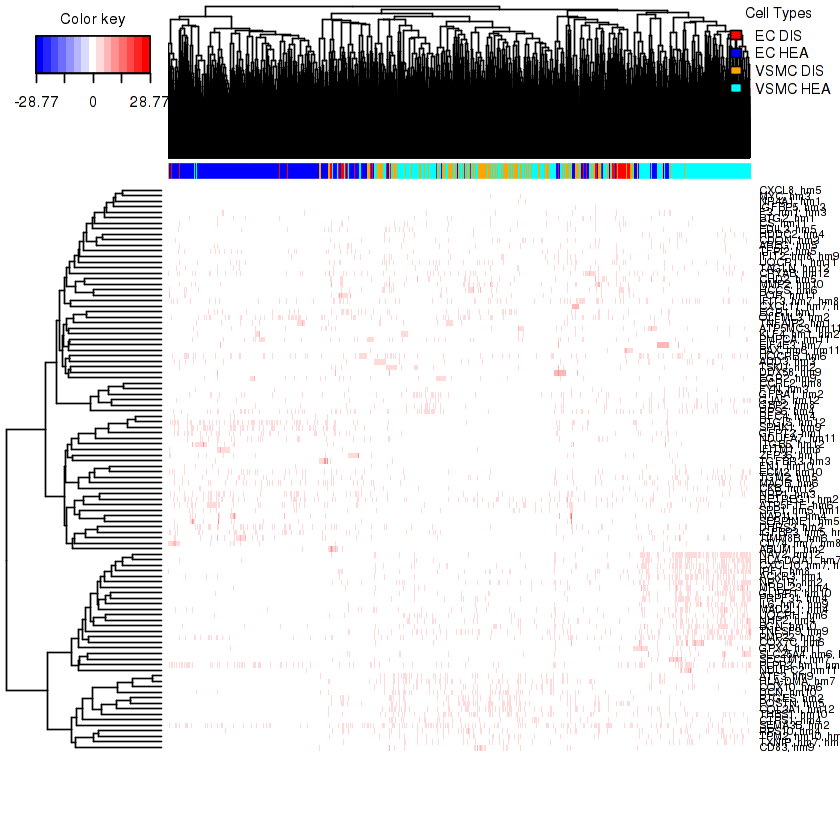

In [169]:
expdatlog3 <- log10(1 + expdat)
expdatlog3 <- t(scale(t(expdatlog3), scale = TRUE, center = FALSE))
my_palettelog3 <- colorRampPalette(c("blue", "white", "red"))(n = 15)
cim(expdatlog3 , dist.method = c('correlation', 'correlation'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = FALSE,
    legend = legendlst, col.names = FALSE, color = my_palettelog3)

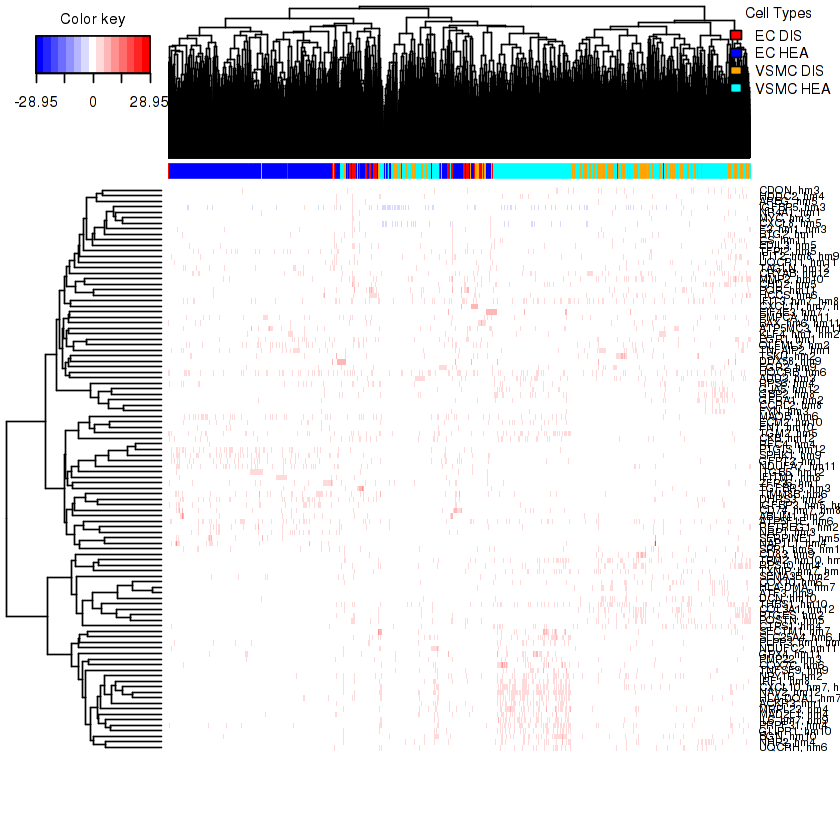

In [172]:
expdatlog4 <- log10(1 + expdat)
expdatlog4 <- t(scale(t(expdatlog4), scale = TRUE, center = TRUE))
my_palettelog4 <- colorRampPalette(c("blue", "white", "red"))(n = 15)
cim(expdatlog4 , dist.method = c('correlation', 'correlation'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = FALSE,
    legend = legendlst, col.names = FALSE, color = my_palettelog4)

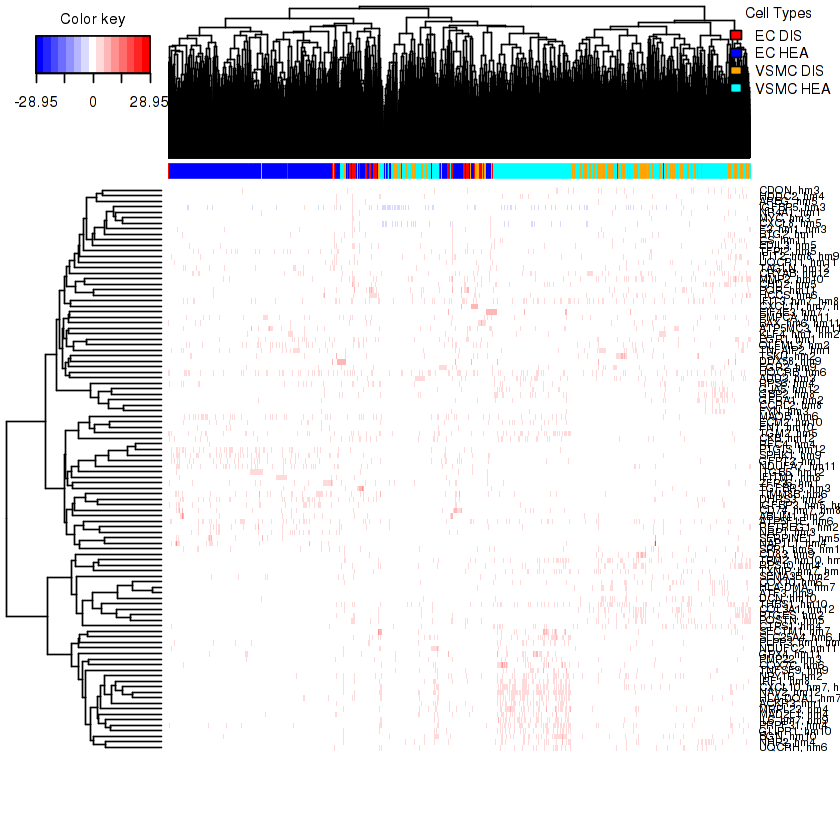

In [173]:
expdatlog5 <- log10(1 + expdat)
# expdatlog5 <- t(scale(t(expdatlog5), scale = TRUE, center = TRUE))
my_palettelog5 <- colorRampPalette(c("blue", "white", "red"))(n = 15)
cim(expdatlog4 , dist.method = c('correlation', 'correlation'), 
    col.sideColors = colData(hm_cds)$sidecolor, scale = TRUE, center = TRUE,
    legend = legendlst, col.names = FALSE, color = my_palettelog5)

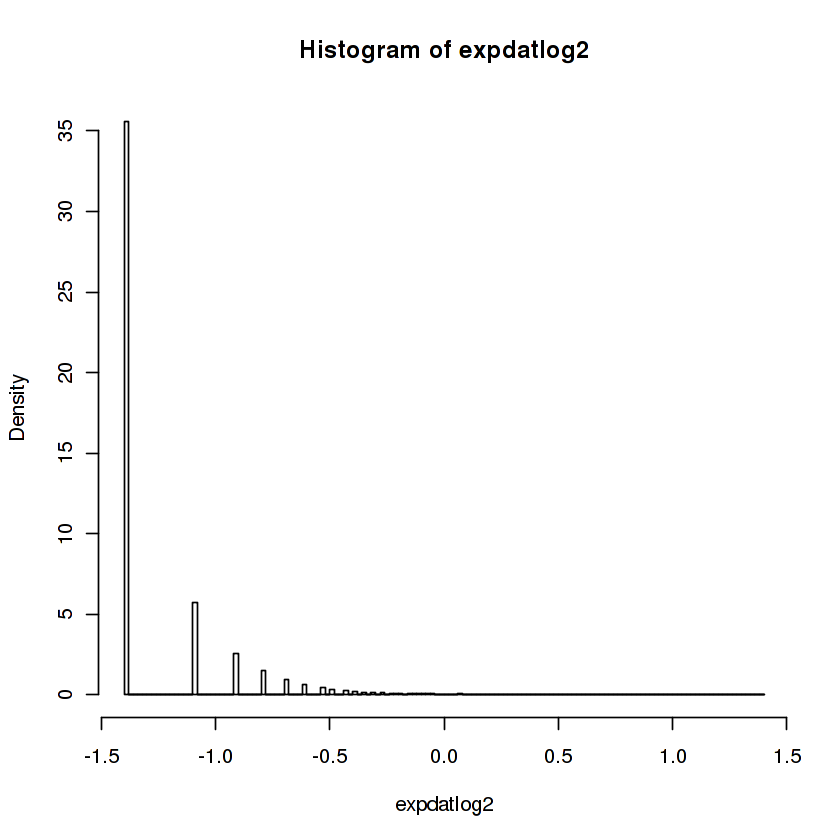

In [188]:
hist(expdatlog2, breaks = 100, freq = FALSE)

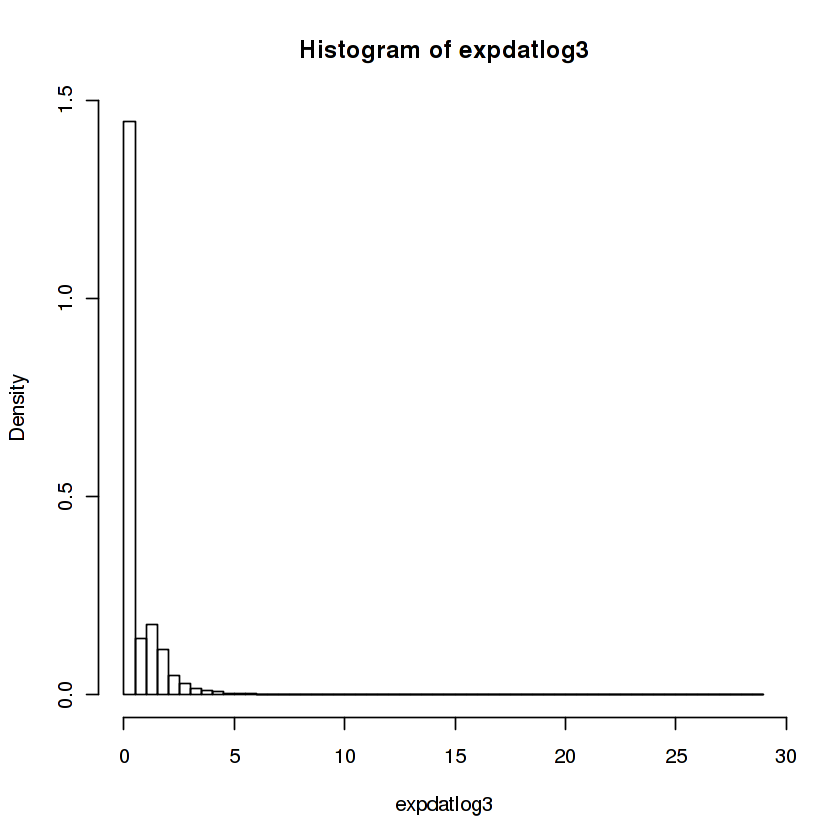

In [189]:
hist(expdatlog3, breaks = 100, freq = FALSE)

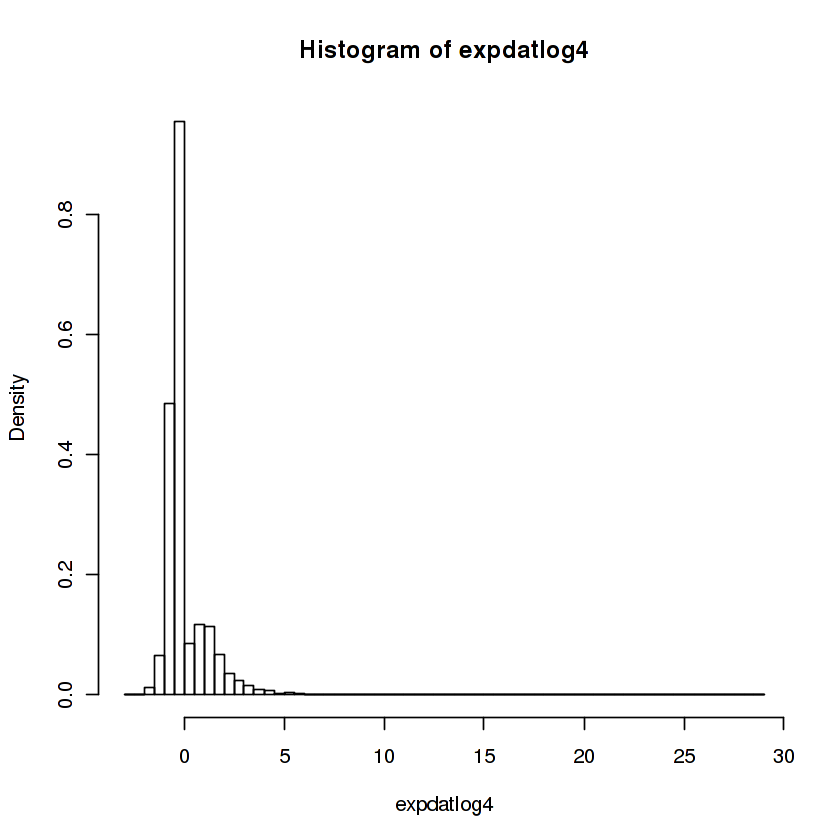

In [176]:
hist(expdatlog4, breaks = 100, freq = FALSE)

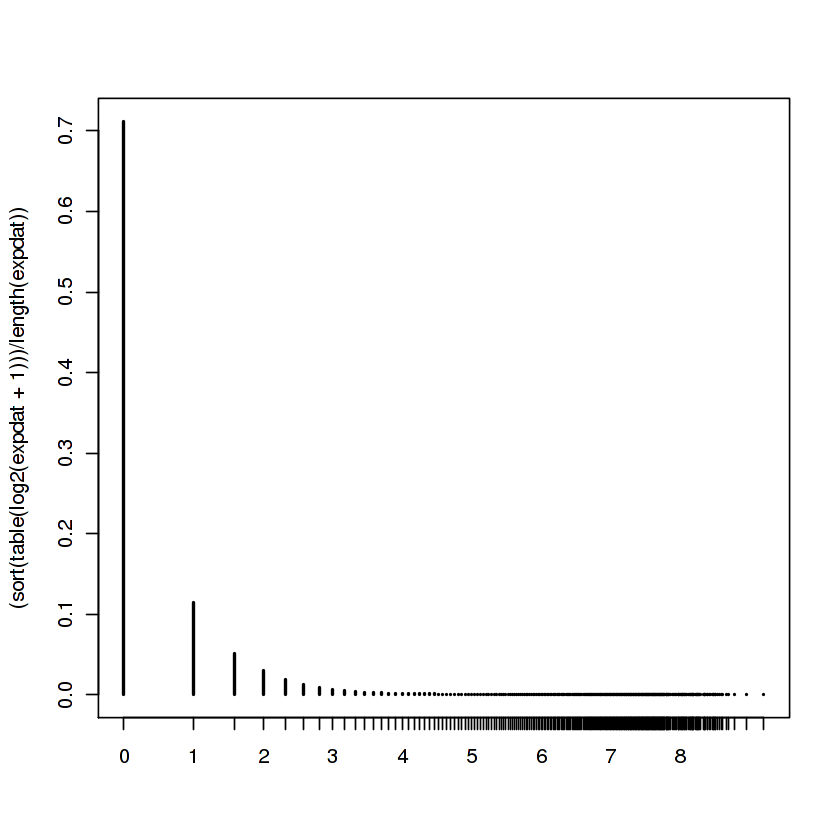

In [185]:
plot((sort(table(log2(expdat + 1)))/length(expdat)))

In [175]:
help(hist)